/tmp/ipython-input-2-1483913619.py:11: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(tickers, start=start_date, end=end_date)['Close']
[*********************100%***********************]  4 of 4 completed


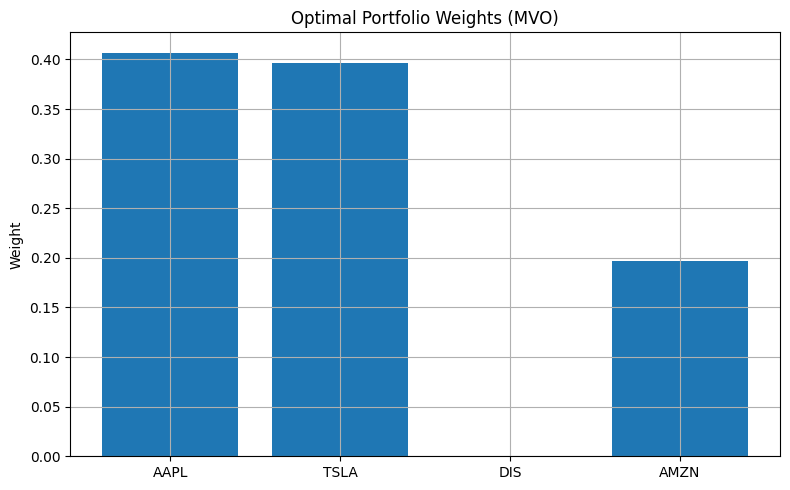

In [2]:
import yfinance as yf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import minimize

tickers = ['AAPL', 'TSLA', 'DIS', 'AMZN']
start_date = '2015-01-01'
end_date = '2025-01-01'

data = yf.download(tickers, start=start_date, end=end_date)['Close']
returns = data.pct_change().dropna()

mean_returns = returns.mean()
cov_matrix = returns.cov()

def portfolio_performance(weights, mean_returns, cov_matrix):
    ret = np.dot(weights, mean_returns) * 252
    vol = np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights))) * np.sqrt(252)
    sharpe = ret / vol
    return ret, vol, sharpe

def neg_sharpe_ratio(weights, mean_returns, cov_matrix):
    return -portfolio_performance(weights, mean_returns, cov_matrix)[2]

def check_sum(weights):
    return np.sum(weights) - 1

num_assets = len(tickers)
init_guess = num_assets * [1. / num_assets]
bounds = tuple((0, 1) for _ in range(num_assets))
constraints = {'type': 'eq', 'fun': check_sum}

result = minimize(neg_sharpe_ratio, init_guess, args=(mean_returns, cov_matrix),
                  method='SLSQP', bounds=bounds, constraints=constraints)

opt_weights = result.x

plt.figure(figsize=(8, 5))
plt.bar(tickers, opt_weights)
plt.title('Optimal Portfolio Weights (MVO)')
plt.ylabel('Weight')
plt.grid(True)
plt.tight_layout()
plt.show()


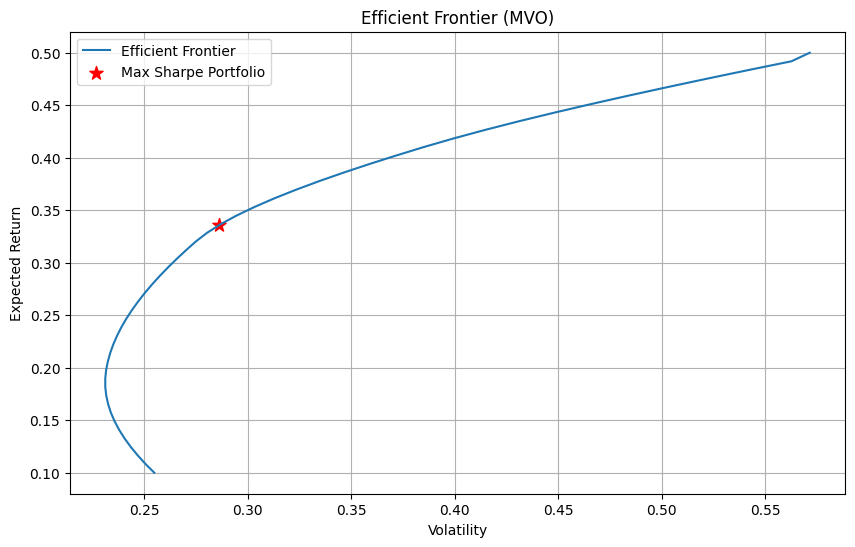

In [3]:
#effective frontier

def portfolio_volatility(weights, mean_returns, cov_matrix):
    return portfolio_performance(weights, mean_returns, cov_matrix)[1]

target_returns = np.linspace(0.1, 0.5, 50)
efficient_portfolios = []

for t_ret in target_returns:
    constraints = (
        {'type': 'eq', 'fun': check_sum},
        {'type': 'eq', 'fun': lambda x: portfolio_performance(x, mean_returns, cov_matrix)[0] - t_ret}
    )
    result = minimize(portfolio_volatility, init_guess, args=(mean_returns, cov_matrix),
                      method='SLSQP', bounds=bounds, constraints=constraints)
    efficient_portfolios.append(result)

vols = [portfolio_performance(p.x, mean_returns, cov_matrix)[1] for p in efficient_portfolios]

plt.figure(figsize=(10,6))
plt.plot(vols, target_returns, label='Efficient Frontier')
opt_ret, opt_vol, _ = portfolio_performance(opt_weights, mean_returns, cov_matrix)
plt.scatter(opt_vol, opt_ret, color='r', marker='*', s=100, label='Max Sharpe Portfolio')
plt.xlabel('Volatility')
plt.ylabel('Expected Return')
plt.title('Efficient Frontier (MVO)')
plt.legend()
plt.grid(True)
plt.show()


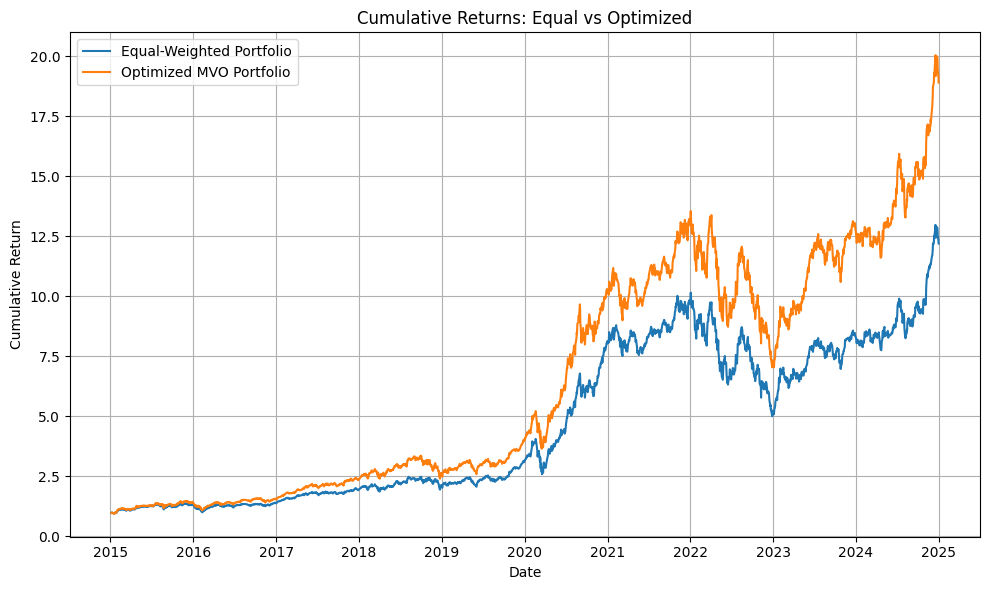

In [4]:
#comnpare equal and optimised portfolio

equal_weights = np.array(num_assets * [1. / num_assets])
returns_eq = returns.dot(equal_weights)
returns_opt = returns.dot(opt_weights)

cumulative_eq = (1 + returns_eq).cumprod()
cumulative_opt = (1 + returns_opt).cumprod()

plt.figure(figsize=(10,6))
plt.plot(cumulative_eq, label='Equal-Weighted Portfolio')
plt.plot(cumulative_opt, label='Optimized MVO Portfolio')
plt.title('Cumulative Returns: Equal vs Optimized')
plt.xlabel('Date')
plt.ylabel('Cumulative Return')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
